![amazon](img/amazon-logo.jpg)

## Product Category:
# $$Sports\ and\ Outdoors\ Reviews$$


---
![MountainBke](img/Mountain-Bike.jpg)
<br>
![climbing](img/climbing.jpg)
<br>
![outdoor-exercise](img/outdoor-exercise.jpg)

---
# Dataset

![aws-s3](img/amazon_aws-s3.png)

<br>
UCSanDiego library/repo Curated by Julian McAuley [Source](http://jmcauley.ucsd.edu/data/amazon/)

https://s3-us-west-2.amazonaws.com/msds-projects/data/reviews_Sports_and_Outdoors_5.json.gz

In [1]:
reset -fs

In [2]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

---
# Part I EDA and Preprocessing
---
### `Download and Unzip Reviews into Pandas DataFrame`

In [3]:
!python load_data.py

Your data already exists in the directory. Enjoy.


In [4]:
# Code provided via http://jmcauley.ucsd.edu/data/amazon/

def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

* Convert compressed file of data into Pandas DataFrame

In [5]:
sports_outdoors = convert_to_DF('reviews_Sports_and_Outdoors_5.json.gz')

In [6]:
print('Dataset size: {:,} words'.format(len(sports_outdoors)))

Dataset size: 296,337 words


In [7]:
sports_outdoors[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014"
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012"
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012"


* **Reformat** $\underline{datetime}$ from raw form.

In [8]:
sports_outdoors["reviewTime"] = pd.to_datetime(sports_outdoors["reviewTime"])

* **Rearrange** the left-to-right by relevance

In [9]:
sports_outdoors = sports_outdoors[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [10]:
sports_outdoors.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200


In [11]:
sports_outdoors.tail(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
296334,B00LFPS0CY,"""Great Water Bottle For Hot Day""......","This Hydracentials Sporty 25 OZ, double insula...",5.0,ASKZO80Z1RKTR,Robin Lee,"[0, 0]",2014-07-21,1405900800
296335,B00LFPS0CY,A pretty impressive water bottle. Best I've s...,As usual I received this item free in exchange...,5.0,APRNS6DB68LLV,"Rob Slaven ""slavenrm@gmail. com""","[1, 1]",2014-07-21,1405900800
296336,B00LFPS0CY,"""Cool"" Bottle!",Hydracentials insulated 25 oz water bottle.Thi...,5.0,A3UJRNI8UR4871,"Wulfstan ""wulfstan""","[2, 2]",2014-07-15,1405382400


---
## Number of Reviews by Unique Products [`asin`]

In [12]:
products = sports_outdoors['overall'].groupby(sports_outdoors['asin']).count()
print("Number of Unique Products in the Sports & Outdoors Category = {}".format(products.count()))

Number of Unique Products in the Sports & Outdoors Category = 18357


**Top 20 Reviewed Products**

In [13]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B001HBHNHE - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B001HBHNHE    1042
B001T7QJ9O     763
B000S5ODN2     647
B0010O748Q     513
B0000C50K3     427
B002ZYRV2E     401
B002OKWHVO     398
B000GCRWCG     393
B001HBHNHY     372
B0035L35A8     359
B004U8CP88     357
B001WJ577O     355
B004TNWD40     349
B006X9DLQM     344
B00178CS4K     343
B006QF3TW4     323
B003NFI092     309
B00200E0HM     307
B001949TKS     298
B000JZ7JM8     293
Name: overall, dtype: int64

Most Reviewed Product, B001HBHNHE - has 1042 reviews.


## $\underline{Most\ Reviewed}$ is a _9mm Pistol Magazine Loader_
[Amazon Product listing](https://www.amazon.com/Maglula-UpLULA-Magazine-Loader-9mm-45/dp/B001HBHNHE)

![pink mag](img/pink-mag.jpg)

# $$That's\ about\ as\ 'Merica\ as\ it\ gits!$$

![Merica flag](img/Merica.gif)
---

In [14]:
sorted_products[9178:9179]

asin
B000NNR93A    9
Name: overall, dtype: int64

## $\underline{Middle-of-the-Road}$ is a _9-Speed Cassette for a Bicycle_
[Amazon Product listing](https://www.amazon.com/SRAM-PG950-9-Speed-Cassette-12-26T/dp/B000NNR93A/ref=sr_1_1?s=sporting-goods&ie=UTF8&qid=1481675376&sr=1-1&keywords=B000NNR93A)

![(9-speed-casstte](img/9-speed-cassette.jpg)

---

**Bottom 20 Reviewed Products**

In [15]:
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[18337:], end='\n\n')
print('Least Reviewed Product (Sorted), B003Z6HUZE - has {} reviews.'.format(products.min()))

Bottom 20 Reviewed Products:

asin
B003VN1U7K    5
B003VZIWZQ    5
B00BFXAIEY    5
B000T1VZCW    5
B000TH4MMG    5
B003XDWY32    5
B000T29STI    5
B003WXR992    5
B003WXJOEA    5
B000TAADTO    5
B00BGI7R38    5
B003WHHXAS    5
B000TTR0JG    5
B003WHA1N4    5
B000TRKTUK    5
B000TTHVYA    5
B003WGUEEG    5
B000TTM3OI    5
B003WDTI78    5
B003Z6HUZE    5
Name: overall, dtype: int64

Least Reviewed Product (Sorted), B003Z6HUZE - has 5 reviews.


## $\underline{Least\ Reviewed}$ is a _2-Position Web Nylon Knife Sheath_
[Amazon Product listing](https://www.amazon.com/2-Position-Nylon-Knife-Sheath-3-Inch/dp/B003Z6HUZE/ref=sr_1_1?s=sporting-goods&ie=UTF8&qid=1481675692&sr=1-1&keywords=B003Z6HUZE)

![Web Nlyon Knife Sheath](img/ruko.jpg)
---

## $\underline{Most\ Common\ Amount\ of\ Reviews} -->$ $5$ Reviews

In [16]:
products.mode()

0    5
dtype: int64

---
## Preprocessing:
### `Remove punctuations, stopwords, and lemmatize`

In [17]:
sports_outdoors['reviewText'][:11]

0     This came in on time and I am veru happy with ...
1     I had a factory Glock tool that I was using fo...
2     If you don't have a 3/32 punch or would like t...
3     This works no better than any 3/32 punch you w...
4     I purchased this thinking maybe I need a speci...
5     Needed this tool to really break down my G22, ...
6     If u don't have it .. Get it. All you need to ...
7     This light will no doubt capture the attention...
8     Light and laser torch work well, very bright. ...
9     Does everything it says it will do. I would li...
10    Very bright.  I would recommend this lite to a...
Name: reviewText, dtype: object

In [18]:
reviews = sports_outdoors['reviewText']

In [19]:
reviews.count()

296337

In [20]:
stops = stopwords.words('english')

In [21]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [22]:
reviews = reviews.apply(lambda x: tokenize(x))

In [23]:
reviews[:11]

0     [This, came, in, on, time, and, I, am, veru, h...
1     [I, had, a, factory, Glock, tool, that, I, wa,...
2     [If, you, do, nt, have, a, 332, punch, or, wou...
3     [This, work, no, better, than, any, 332, punch...
4     [I, purchased, this, thinking, maybe, I, need,...
5     [Needed, this, tool, to, really, break, down, ...
6     [If, u, do, nt, have, it, , Get, it, , All, yo...
7     [This, light, will, no, doubt, capture, the, a...
8     [Light, and, laser, torch, work, well, , very,...
9     [Does, everything, it, say, it, will, do, , I,...
10    [Very, bright, , I, would, recommend, this, li...
Name: reviewText, dtype: object

---
# Part II Modeling
---
## Model data

> **[ 1 ]** Classification / Sentiment Analysis ( Logistic Regression, MultinomialNB )

> **[ 2 ]** Clustering / Topic Modeling ( NMF and Lda )

# `Classification / Sentiment Analysis (LogReg, Mulitnomial)`

In [24]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(sports_outdoors.reviewText))

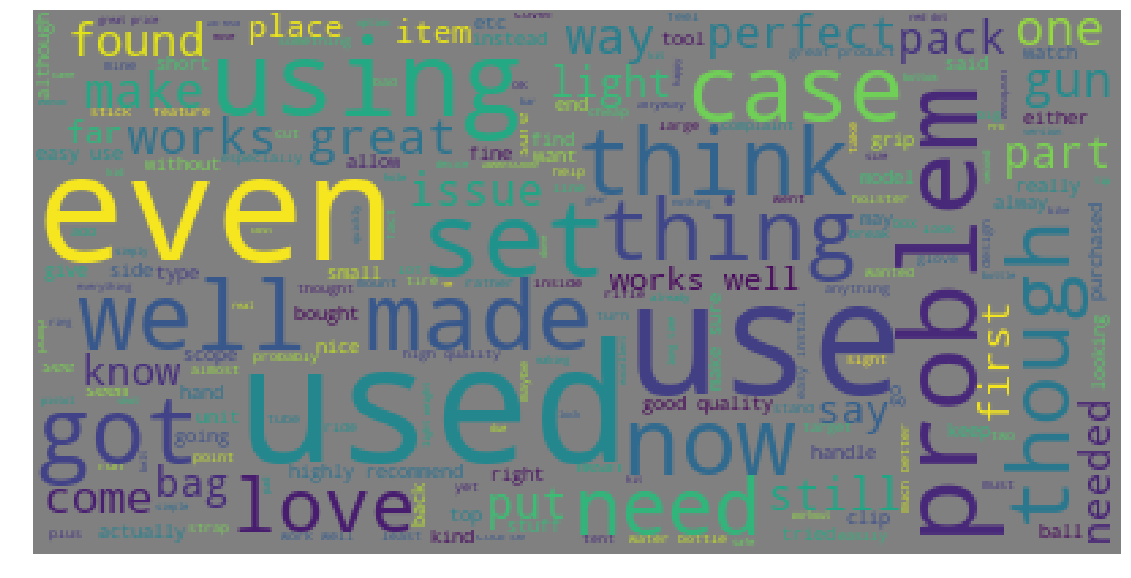

In [25]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

In [26]:
sports_outdoors[:3]

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200


### Insert `pos_neg` column for Sentiment modeling

         Negative reviews:      1-3 Stars  = 0
         Positive reviews:      4-5 Stars  = 1

   ![star](img/amazon-stars.png)

In [27]:
sports_outdoors['pos_neg'] = [1 if x > 3 else 0 for x in sports_outdoors.overall]

In [28]:
sports_outdoors.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,pos_neg
0,1881509818,Woks very good,This came in on time and I am veru happy with ...,5.0,AIXZKN4ACSKI,David Briner,"[0, 0]",2014-01-26,1390694400,1
1,1881509818,Works as well as the factory tool,I had a factory Glock tool that I was using fo...,5.0,A1L5P841VIO02V,Jason A. Kramer,"[1, 1]",2012-02-02,1328140800,1
2,1881509818,"It's a punch, that's all.",If you don't have a 3/32 punch or would like t...,4.0,AB2W04NI4OEAD,J. Fernald,"[2, 2]",2012-02-28,1330387200,1


In [29]:
review_text = sports_outdoors["reviewText"]

### Train/Test Split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(sports_outdoors.reviewText, sports_outdoors.pos_neg, random_state=0)

In [31]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (222252,)
y_train shape: (222252,)

x_test shape: (74085,)
y_test shape: (74085,)



---
# `Logistic Regression`

## `CountVectorizer`

In [32]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<222252x28733 sparse matrix of type '<class 'numpy.int64'>'
	with 12428687 stored elements in Compressed Sparse Row format>


In [33]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 28733


---
## Logistic Regression 
### on Training data

In [34]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

In [35]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.888


---

In [36]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

In [37]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

Accuracy:   0.890


In [38]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test))) 

Training set score: 0.907
Test set score: 0.890


In [39]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 4644  6290]
 [ 1831 61320]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


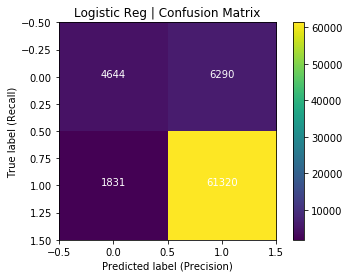

In [40]:
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [41]:
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.938


### GridSearchCV on $\underline{Training\ data}$ to _Increase Performance_

In [42]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.891
Best parameters:  {'C': 0.1}


### _Apply Best Parameters_ from GridSearchCV on $\underline{Testing\ data}$

In [44]:
print("{:.3f}".format(grid.score(X_test, y_test)))

0.890


In [45]:
grid_log_f1 = f1_score(y_test, log_y_pred)
print("Grid Logistic Reg - F1 score: {:.3f}".format(grid_log_f1))

Grid Logistic Reg - F1 score: 0.938


In [46]:
y_pred = grid.predict(X_test)

In [47]:
cnf_matrix = confusion_matrix(y_test, y_pred)

---
## `TfidfVectorizer` with Pipeline through `GridSearchCV`

In [48]:
# Attempt one ... with no Test phase
pipeline = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
tfidf_param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

tfidf_grid = GridSearchCV(pipeline, tfidf_param_grid, cv=5)
tfidf_grid.fit(x_train, y_train)

print("Best cross-validation score: {:.3f}".format(tfidf_grid.best_score_))
print("Best parameters: ", tfidf_grid.best_params_)

Best cross-validation score: 0.892
Best parameters:  {'logisticregression__C': 0.001}


### Attempt two ... Ran for 4 hours and only completed one Fold  : (

In [49]:
# Code Excerpt Adapted From: “Python Machine Learning.” iBooks. pg.403-404 

# tfidf_vect = TfidfVectorizer(strip_accents=None,
#                              lowercase=False,
#                              preprocessor=None)

# tfidf_param_grid = [{'vect__ngram_range': [(1,1)],
#                       'vect__stop_words': [stops, None],
#                       'vect__tokenizer': [tokenizer2],
#                       'clf__penalty': ['l1', 'l2'],
#                       'clf__C': [1.0, 10.0, 100.0]},
#                      {'vect__ngram_range': [(1,1)],
#                       'vect__stop_words': [stops, None],
#                       'vect__tokenizer': [tokenizer2],
#                       'vect__use_idf':[False],
#                       'vect__norm':[None],
#                       'clf__penalty': ['l1', 'l2'],
#                       'clf__C': [1.0, 10.0, 100.0]}
#                     ]

# lr_tfidf = Pipeline([('vect', tfidf_vect),
#                      ('clf',
#                       LogisticRegression(random_state=0))])

# gs_lr_tfidf = GridSearchCV(lr_tfidf, tfidf_param_grid,
#                            scoring='accuracy',
#                            cv=5, verbose=1,
#                            n_jobs=-1)

# gs_lr_tfidf.fit(x_train, y_train)

---
## Multinomial Bayes 
### on Training data

## `CountVectorizer`

In [50]:
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [51]:
mnb_y_pred = mnb.predict(X_test)

In [52]:
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score))

Accuracy:   0.865


In [53]:
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))

Training set score: 0.883
Test set score: 0.865


In [54]:
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 5968  4966]
 [ 5009 58142]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


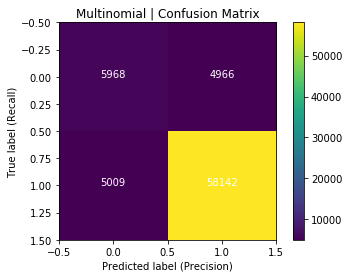

In [55]:
plt.imshow(mnb_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [56]:
mnb_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb_f1))

Multinomial NB - F1 score: 0.921


## `TfidfVectorizer`

In [57]:
# Vectorize X_train
mnb_tfidfvectorizer = TfidfVectorizer(min_df=5).fit(x_train)
mnb_X_train = mnb_tfidfvectorizer.transform(x_train)
print("X_train:\n{}".format(repr(mnb_X_train)))

X_train:
<222252x28733 sparse matrix of type '<class 'numpy.float64'>'
	with 12428687 stored elements in Compressed Sparse Row format>


In [58]:
mnb_X_test = mnb_tfidfvectorizer.transform(x_test)

mnb_y_pred = mnb.predict(mnb_X_test)

In [59]:
mnb_score2 = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score2))

Accuracy:   0.856


In [60]:
print("Training set score: {:.3f}".format(mnb.score(mnb_X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(mnb_X_test, y_test)))

Training set score: 0.861
Test set score: 0.856


In [61]:
mnb_cfm2 = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm2, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[  312 10622]
 [   42 63109]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


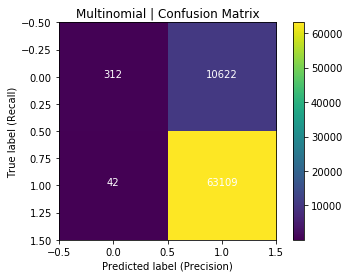

In [62]:
plt.imshow(mnb_cfm2, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm2.shape[0]), range(mnb_cfm2.shape[1])):
    plt.text(j, i, mnb_cfm2[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [63]:
mnb2_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb2_f1))

Multinomial NB - F1 score: 0.922


### Summary:

* Logistic with TF wins!

* Multinomial NB with Tfidf in second.

* Take aways - What could SVM or Random Forest result in? What's going with Logistic Tfidf?

---

# `Clustering / Topic Modeling (NMF and Lda)`

---
## Clustering Vectorize:
### `CountVectorizer` & `Tf-idf`


* With NLTK stopwords 

In [64]:
# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

In [65]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 124407


---
## Build Clustering Models:
## `Nonnegative Matrix Factorization (NMF)` 
### & 
## `Latent Dirichlet Allocation (Lda)`

In [66]:
# Initialize NMF
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)

# Initialize Ida
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [67]:
num_top_words = 15

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

## `Term frequency` [ tf ]

## NMF

In [68]:
nmf_tf = nmf.fit(tf)

In [69]:
nmf_ = nmf_tf.transform(tf)
Counter([np.argmax(i) for i in nmf_])

Counter({0: 52626,
         1: 18374,
         2: 14866,
         3: 14056,
         4: 25615,
         5: 15183,
         6: 66406,
         7: 47307,
         8: 12275,
         9: 29629})

In [70]:
retrieve_top_words(nmf_tf, tfidf_feature_names, num_top_words)

Topic #0:
use get time would also used back using much water need even work first easy

Topic #1:
knife blade handle knives steel sheath sharp edge pocket good well would clip use hand

Topic #2:
bike rack seat bikes lock ride road tire front riding rear tires frame chain put

Topic #3:
bag water pack small carry pocket bottle strap fit bags top side straps well compartment

Topic #4:
one two bought another buy got first new side thing years time back amazon even

Topic #5:
light bright battery batteries lights mount mode led night see use lantern red low enough

Topic #6:
good well would scope gun made price quality fit sight rifle product nice case range

Topic #7:
great works price product easy quality love little buy bought recommend work fits fit perfect

Topic #8:
34 size fit belt holster small little large grip pistol case right long fits waist

Topic #9:
like really much would feel little also looks better thing look nice think size something




### ..........<  `NMF / tf Topics`  >..........

    Topic #0:
    use get time would also used back using much water need even work first easy

**[ Water Bottle/Purification ]**

    Topic #1:
    knife blade handle knives steel sheath sharp edge pocket good well would clip use hand

**[ Knives and accessories ]**

    Topic #2:
    bike rack seat bikes lock ride road tire front riding rear tires frame chain put
    
**[ Biking ]**

    Topic #3:
    bag water pack small carry pocket bottle strap fit bags top side straps well compartment
    
**[ Backpacking ]**

    Topic #4:
    one two bought another buy got first new side thing years time back amazon even
    
**[ ??? ]**

    Topic #5:
    light bright battery batteries lights mount mode led night see use lantern red low enough
    
**[ Lanterns/Flashlights ]**

    Topic #6:
    good well would scope gun made price quality fit sight rifle product nice case range
    
**[ Rifle/shooting equipment ]**

    Topic #7:
    great works price product easy quality love little buy bought recommend work fits fit perfect
    
**[ -- Positive Feedback -- ]**

    Topic #8:
    34 size fit belt holster small little large grip pistol case right long fits waist
    
**[ Pistol/shooting equipment ]**

    Topic #9:
    like really much would feel little also looks better thing look nice think size something
    
**[ -- Positive Feedback -- ]**

## Lda

In [71]:
lda_tf = lda.fit(tf)

C:\Users\divanshu\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [72]:
lda_ = lda_tf.transform(tf)
Counter([np.argmax(i) for i in lda_])

Counter({0: 113757,
         1: 30429,
         2: 38344,
         3: 38588,
         4: 29083,
         5: 869,
         6: 24005,
         7: 2616,
         8: 10653,
         9: 7993})

In [73]:
retrieve_top_words(lda_tf, tfidf_feature_names, num_top_words)

Topic #0:
use one like well would get great really also time need much keep little good

Topic #1:
bike easy side front mount use tool ride one fit rack back lock screw rear

Topic #2:
like one would plastic good get looks time better much thing watch really first little

Topic #3:
great good price well quality 34 product would made buy recommend works one fit like

Topic #4:
knife blade handle steel sharp one knives sheath like good edge great well pocket use

Topic #5:
light battery bright batteries laser installed green rain power red pedometer lantern computer data charger

Topic #6:
gun scope sight rifle range holster ar shooting pistol rail rounds sights 22 stock use

Topic #7:
bag pack small carry pocket gear pockets phone side camping inside bags velcro fire stuff

Topic #8:
ball one color old set tent minutes got fun back stand kids year 25 34

Topic #9:
water bottle clean use stove cleaning kit bottles hot pot cup lid used cap drink




### ..........<  `Lda / tf Topics`  >..........
    Topic #0:
    use one like well would get great really also time need much keep little good
    
**[ -- Positive Feedback -- ]**

    Topic #1:
    bike easy side front mount use tool ride one fit rack back lock screw rear
    
**[ Biking ]**

    Topic #2:
    like one would plastic good get looks time better much thing watch really first little
    
**[ ??? ]**

    Topic #3:
    great good price well quality 34 product would made buy recommend works one fit like
    
**[ -- Positive Feedback ]**

    Topic #4:
    knife blade handle steel sharp one knives sheath like good edge great well pocket use
    
**[ Knives and accessories ]**

    Topic #5:
    light battery bright batteries laser installed green rain power red pedometer lantern computer data charger
    
**[ Outdoor Electronics ]**

    Topic #6:
    gun scope sight rifle range holster ar shooting pistol rail rounds sights 22 stock use
    
**[ Shooting ]**

    Topic #7:
    bag pack small carry pocket gear pockets phone side camping inside bags velcro fire stuff
    
**[ Backpacking ]**

    Topic #8:
    ball one color old set tent minutes got fun back stand kids year 25 34
    
**[ ??? ]**

    Topic #9:
    water bottle clean use stove cleaning kit bottles hot pot cup lid used cap drink
    
**[ Water bottle/Cooking ]**

## `Term frequency-inverse document frequency` [ tfidf ]

## NMF

In [74]:
nmf_tfidf = nmf.fit(tfidf)

In [75]:
nmf_W = nmf_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in nmf_W])

Counter({0: 109098,
         1: 21925,
         2: 26765,
         3: 22902,
         4: 24061,
         5: 23085,
         6: 11945,
         7: 14761,
         8: 28261,
         9: 13534})

In [76]:
retrieve_top_words(nmf_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
one like use get would time little really much used better need work bought also

Topic #1:
knife blade sharp sheath knives handle edge steel pocket carry hand open clip box edc

Topic #2:
great works product price easy recommend buy love looks use highly work item would install

Topic #3:
scope sight rifle mount dot sights rail 22 red rings gun ar zero range mounted

Topic #4:
bike light bright easy rack road seat ride riding bikes mount lights install tire mountain

Topic #5:
good quality price product buy nice looks pretty would value recommend high seems money job

Topic #6:
34 size fit waist large belt length case barrel medium shorts tactical ordered fits small

Topic #7:
bag pack carry sleeping small bags range room bug pockets straps kit gear stuff strap

Topic #8:
well made fit holster works fits belt nice holds perfectly work seems built gun comfortable

Topic #9:
water bottle bottles drink filter cold cap ice nalgene cage cup drinking clean taste mouth




### ..........<  `NMF / tfidf Topics`  >..........

    Topic #0:
    one like use get would time little really much used better need work bought also
    
**[ -- Positive Feedback -- ]**

    Topic #1:
    knife blade sharp sheath knives handle edge steel pocket carry hand open clip box edc
    
**[ Knives and accessories ]**

    Topic #2:
    great works product price easy recommend buy love looks use highly work item would install
    
**[ -- Positive Feedback -- ]**

    Topic #3:
    scope sight rifle mount dot sights rail 22 red rings gun ar zero range mounted
    
**[ Rifle scopes/mounting ]**

    Topic #4:
    bike light bright easy rack road seat ride riding bikes mount lights install tire mountain
    
**[ Biking ]**

    Topic #5:
    good quality price product buy nice looks pretty would value recommend high seems money job
    
**[ -- Postive Feedback -- ]**

    Topic #6:
    34 size fit waist large belt length case barrel medium shorts tactical ordered fits small
    
**[ Shooting accessories ]**

    Topic #7:
    bag pack carry sleeping small bags range room bug pockets straps kit gear stuff strap
    
**[ Backpacking ]**

    Topic #8:
    well made fit holster works fits belt nice holds perfectly work seems built gun comfortable
    
**[ Pistol holster(s) ]**

    Topic #9:
    water bottle bottles drink filter cold cap ice nalgene cage cup drinking clean taste mouth
    
**[ Water Bottles ( Nalgene ) ]**

## Lda

In [77]:
lda_tfidf = lda.fit(tfidf)

C:\Users\divanshu\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [78]:
lda_W = lda_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in lda_W])

Counter({0: 295709,
         1: 48,
         2: 48,
         3: 26,
         4: 30,
         5: 232,
         6: 119,
         7: 33,
         8: 46,
         9: 46})

In [79]:
retrieve_top_words(lda_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
great good well one like use would knife get easy price product works light little

Topic #1:
strobe drills lasers darts 556 speedsafe ghost p15 finder p22 prob 1800 kicked th madden

Topic #2:
tomahawk hydro 8221 laserlyte tipton component golfing reloader blah jaw 8220 triathlon mp5 gather romanian

Topic #3:
stud uncle plugged emailed messenger tcp agility mike quickster snakes 62x54r spanner motorists technically trophy

Topic #4:
dpms golfer 8230 readings retaining wireless apps samsung tablet industries callaway tek swords cuff evaluation

Topic #5:
water bottle stove pot bottles filter cup fuel lid canteen coffee hot taste cooking mouth

Topic #6:
levers witness cygolite monkey rcbs pt trx pi ti crossbows 9658 mma headphone silky ons

Topic #7:
nikon carabiner lil tights bdc turrets acog cree blurry freewheel sightmark boresighter leapers prescription rips

Topic #8:
clubs bivy strands froglube insanity http www sr carabiners ref bcm gp sunday stacker organizing

Topic

### ..........<  `Lda / tfidf Topics`  >..........

    Topic #0:
    great good well one like use would knife get easy price product works light little
    
** [ -- Positive Feedback .. Knife? -- ] **

    Topic #1:
    strobe drills lasers darts 556 speedsafe ghost p15 finder p22 prob 1800 kicked th madden
    
** [ Madden (Shoes) ] **

    Topic #2:
    tomahawk hydro 8221 laserlyte tipton component golfing reloader blah jaw 8220 triathlon mp5 gather romanian
    
** [ Tipton (Rifle cleaning kit) ] **

    Topic #3:
    stud uncle plugged emailed messenger tcp agility mike quickster snakes 62x54r spanner motorists technically trophy
    
** [ ??? ] **

    Topic #4:
    dpms golfer 8230 readings retaining wireless apps samsung tablet industries callaway tek swords cuff evaluation
    
** [ Samsumg, tablet, wireless, apps ] **

    Topic #5:
    water bottle stove pot bottles filter cup fuel lid canteen coffee hot taste cooking mouth
    
** [ _Camping_ ] **

    Topic #6:
    levers witness cygolite monkey rcbs pt trx pi ti crossbows 9658 mma headphone silky ons
    
** [ Cygolite (headlamp) ] **

    Topic #7:
    nikon carabiner lil tights bdc turrets acog cree blurry freewheel sightmark boresighter leapers prescription rips
    
** [ Nikon (scopes/cameras) ] **

    Topic #8:
    clubs bivy strands froglube insanity http www sr carabiners ref bcm gp sunday stacker organizing
    
** [ bivy (sleepingbag-tents) ] **

    Topic #9:
    invicta wahoo golfers hoodie buttpad shades pachmayr mako headbands cop baseballs koozie setups void benelli
    
** [ Invicta (watch), Pachmayr (handgun grips), Mako (fishing), Benelli (Rifle) ] **

### Summary:

* Both **NMF and Lda with tf** were about the same and just ok.


* **NMF with tfidf** was the best - with no obsure topics and even correctly associated a topic with a Brand (Nalgene)


* **Lda with tfidf** was primarily a unassociated words
        However - it did return the most specific and unique words out of them all (i.e. brand news)

---
# $$NEXT\ STEPs$$

### Model Tweaking or Fix:
* Effectively handle Imbalance
* Figure out what happened with `TfidfVectorizer` with Pipeline through `GridSearchCV`
* Random Forest:

---
### Random Forest
>### [ `X` ] _tfidf-vectorized reviews_

>### [ `y` ] _Overall scores_

In [80]:
# Random Forest on tfidf_vectorized (X) ; overall scores (y)

# Accuracy scores
# Confusion matrix
# F1 score

### Further Application/Productization:
* `Recommendation Engine: Collaborative filtering & Factorization Machine`
* Scraping `REI` and/or other sports ecommerce sites in order to build a better, more robust `Recommendation Engine` for Sports and Outdoors products -- to reach the goal of a **Recommendation Engine Chatbot for Sports and Outdoors Products** (for say Facebook or Slack)

#      $$Questions?  $$  